In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from laplace_hdc_helper import load_dataset
from laplace_hdc_classifier_1d import train_hdc_classifier, test_hdc_classifier
from laplace_hdc_encoder_1d import hdc_encoder
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from scipy.io import savemat, loadmat
from torch.utils.data import TensorDataset, DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device:\t{device}")

Using device:	cuda:0


### Hyperparameters

In [2]:
hyperdim = 5000 
bandwidth_parameter = 3 # bandwidth parameter
encoder_mode = 'shift_1d'
classifier_mode="float_sgd"
epochs=10

## Load Data

In [3]:
def load_ucr(file):
    data = np.loadtxt(file)
    X = data[:, 1:]
    y = data[:, 0]
    y = np.where(y == 1, 1, 0)  # convert labels to 0/1
    return X, y

# Adjust file paths to your local files
X_train, y_train = load_ucr("../FordA_TRAIN.txt")
X_test, y_test = load_ucr("../FordA_TEST.txt")

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ——— Normalization step (min-max per feature) ———
X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)

denom = (X_max - X_min)
denom[denom == 0] = 1   # avoid division by zero

X_train_norm = (X_train - X_min) / denom
X_test_norm  = (X_test  - X_min) / denom

# Optional: clip to [0,1] just in case
X_train_norm = np.clip(X_train_norm, 0, 1)
X_test_norm  = np.clip(X_test_norm, 0, 1)

# ——— Prepare tensors & dataloaders ———
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train_tensor = torch.tensor(X_train_norm)
x_test_tensor  = torch.tensor(X_test_norm)

train_data = TensorDataset(x_train_tensor, torch.tensor(y_train))
test_data  = TensorDataset(x_test_tensor, torch.tensor(y_test))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32)

Train shape: (3601, 500), Test shape: (1320, 500)


## Kernel Matrix Construction

lambda = 0.03657161175246486
500


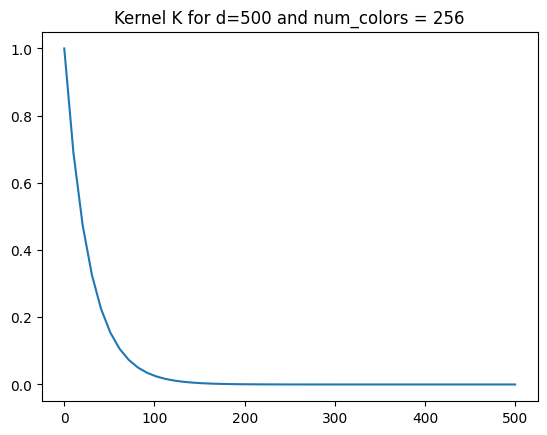

In [4]:
# Determining Lambda from random 1000 samples
batch_size = 1024
num_colors = 256

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1)

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = bandwidth_parameter/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
print(d)
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

## Classification

In [5]:
dataset_name = 'FordA'
try:
    NHDC = loadmat(f'../{dataset_name}_nHD.mat')[f'{dataset_name}_nHD']
    hyperdims = np.mean(NHDC, axis=1, dtype=int)

except:
    hyperdims = range(1000, 5500, 500)

hyperdims

array([ 5000,  6000,  7000,  8000,  9000, 10000, 11000, 12000, 13000,
       14000, 15000, 16000, 17000, 18000, 19000, 20000])

In [6]:
num_workers = 0
pin_memory=False
n_splits = 10
split_size = len(test_data) // n_splits
hyperdims = hyperdims
accuracies = np.zeros((len(hyperdims), n_splits))
num_classes=2
for i, nHDC in enumerate(hyperdims):
    print(f'Hyperdimension: {nHDC} Started --------------')
    # Train
    encoder = hdc_encoder(d, nHDC, kernel, encoder_mode)
    train_hdc = encoder.encode(train_loader)
    train_loader_hdc = DataLoader(
        train_hdc,
        batch_size=10,
        shuffle=True,
        num_workers=0,      # <-- no background workers
        pin_memory=False    # <-- nothing to pin; data is on GPU
    )
    model = train_hdc_classifier(train_loader_hdc, num_classes, mode=classifier_mode, epochs=10)
    print(f'Encoding Train Data and Training the Model for nHDC={nHDC} finished')
    for split_idx in tqdm(range(n_splits)):
        # Test
        start_idx = split_idx * split_size
        end_idx = start_idx + split_size
        split_subset = Subset(test_data, range(start_idx, end_idx))
        split_loader = DataLoader(
            split_subset,
            batch_size=128,
            shuffle=False,
            num_workers=num_workers,   # 2, as you set above
            pin_memory=pin_memory      # True
        )
        split_hdc = encoder.encode(split_loader)
        split_loader_hdc = DataLoader(
            split_hdc,
            batch_size=128,
            shuffle=True,
            num_workers=0,
            pin_memory=False
        )
        accuracies[i, split_idx] = test_hdc_classifier(model, split_loader_hdc)
    print(f'Hyperdimension: {nHDC} Finished. Average Accuracy over 20 splits: {np.mean(accuracies[i])}')


Hyperdimension: 5000 Started --------------
Encoding Train Data and Training the Model for nHDC=5000 finished


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Hyperdimension: 5000 Finished. Average Accuracy over 20 splits: 0.6113636363636362
Hyperdimension: 6000 Started --------------
Encoding Train Data and Training the Model for nHDC=6000 finished


100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


Hyperdimension: 6000 Finished. Average Accuracy over 20 splits: 0.625
Hyperdimension: 7000 Started --------------
Encoding Train Data and Training the Model for nHDC=7000 finished


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Hyperdimension: 7000 Finished. Average Accuracy over 20 splits: 0.6113636363636364
Hyperdimension: 8000 Started --------------
Encoding Train Data and Training the Model for nHDC=8000 finished


100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


Hyperdimension: 8000 Finished. Average Accuracy over 20 splits: 0.6189393939393939
Hyperdimension: 9000 Started --------------
Encoding Train Data and Training the Model for nHDC=9000 finished


100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


Hyperdimension: 9000 Finished. Average Accuracy over 20 splits: 0.6772727272727272
Hyperdimension: 10000 Started --------------
Encoding Train Data and Training the Model for nHDC=10000 finished


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Hyperdimension: 10000 Finished. Average Accuracy over 20 splits: 0.6295454545454546
Hyperdimension: 11000 Started --------------
Encoding Train Data and Training the Model for nHDC=11000 finished


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Hyperdimension: 11000 Finished. Average Accuracy over 20 splits: 0.6272727272727272
Hyperdimension: 12000 Started --------------
Encoding Train Data and Training the Model for nHDC=12000 finished


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Hyperdimension: 12000 Finished. Average Accuracy over 20 splits: 0.6303030303030303
Hyperdimension: 13000 Started --------------
Encoding Train Data and Training the Model for nHDC=13000 finished


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Hyperdimension: 13000 Finished. Average Accuracy over 20 splits: 0.6522727272727271
Hyperdimension: 14000 Started --------------
Encoding Train Data and Training the Model for nHDC=14000 finished


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


Hyperdimension: 14000 Finished. Average Accuracy over 20 splits: 0.6734848484848485
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for nHDC=15000 finished


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Hyperdimension: 15000 Finished. Average Accuracy over 20 splits: 0.6583333333333334
Hyperdimension: 16000 Started --------------
Encoding Train Data and Training the Model for nHDC=16000 finished


100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


Hyperdimension: 16000 Finished. Average Accuracy over 20 splits: 0.6924242424242425
Hyperdimension: 17000 Started --------------
Encoding Train Data and Training the Model for nHDC=17000 finished


100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


Hyperdimension: 17000 Finished. Average Accuracy over 20 splits: 0.6378787878787879
Hyperdimension: 18000 Started --------------
Encoding Train Data and Training the Model for nHDC=18000 finished


100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


Hyperdimension: 18000 Finished. Average Accuracy over 20 splits: 0.6674242424242425
Hyperdimension: 19000 Started --------------
Encoding Train Data and Training the Model for nHDC=19000 finished


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Hyperdimension: 19000 Finished. Average Accuracy over 20 splits: 0.6901515151515152
Hyperdimension: 20000 Started --------------
Encoding Train Data and Training the Model for nHDC=20000 finished


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

Hyperdimension: 20000 Finished. Average Accuracy over 20 splits: 0.6606060606060606


In [7]:
accuracies

array([[0.68181818, 0.62878788, 0.56060606, 0.63636364, 0.64393939,
        0.58333333, 0.60606061, 0.56818182, 0.64393939, 0.56060606],
       [0.62121212, 0.62878788, 0.61363636, 0.57575758, 0.66666667,
        0.66666667, 0.59090909, 0.66666667, 0.63636364, 0.58333333],
       [0.63636364, 0.63636364, 0.61363636, 0.65151515, 0.62878788,
        0.59090909, 0.59848485, 0.59090909, 0.62878788, 0.53787879],
       [0.58333333, 0.60606061, 0.61363636, 0.62121212, 0.56818182,
        0.60606061, 0.65151515, 0.6969697 , 0.56818182, 0.67424242],
       [0.66666667, 0.65151515, 0.75      , 0.70454545, 0.66666667,
        0.61363636, 0.67424242, 0.65909091, 0.6969697 , 0.68939394],
       [0.61363636, 0.62121212, 0.67424242, 0.59090909, 0.62121212,
        0.61363636, 0.59090909, 0.65151515, 0.62121212, 0.6969697 ],
       [0.56060606, 0.65909091, 0.62878788, 0.62121212, 0.66666667,
        0.57575758, 0.57575758, 0.67424242, 0.67424242, 0.63636364],
       [0.56818182, 0.6969697 , 0.6515151

In [8]:
savemat('FordA_LaplaceHDC.mat', {'FordA_LaplaceHDC': accuracies*100})